# Template Matching Trial

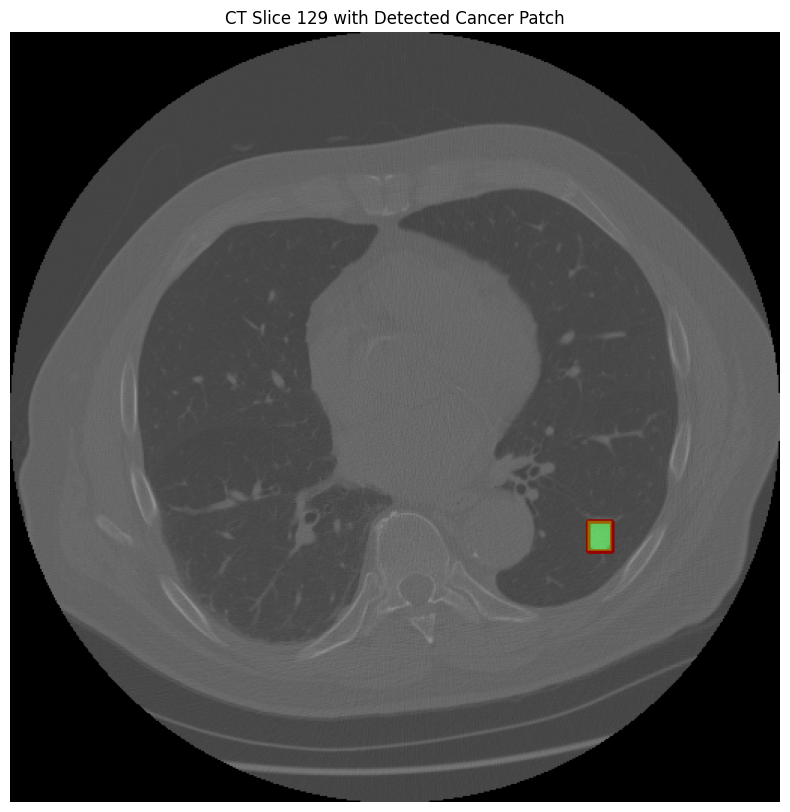

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------
# File paths (adjust if needed)
# -----------------------
ct_scan_path = "../test_processed/3246/3246_full_volume.npy"
mask_path    = "../test_processed/3246/22_asrg_mask.npy"

# -----------------------
# Load the volumes
# -----------------------
ct_volume   = np.load(ct_scan_path)  # CT scan in HU values
mask_volume = np.load(mask_path)     # Mask volume (same dimensions; nonzero only at ROI)

# -----------------------
# Select a CT slice (and corresponding mask slice)
# -----------------------
slice_index = 129  # change this index to view a different slice
ct_slice   = np.squeeze(ct_volume[slice_index])
mask_slice = np.squeeze(mask_volume[slice_index])

# -----------------------
# Normalize the CT slice for display/matching
# -----------------------
# CT HU values may span a wide range so we normalize to [0, 255]
ct_min = np.min(ct_slice)
ct_max = np.max(ct_slice)
ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)

# -----------------------
# Process the mask slice
# -----------------------
# If the mask is binary (values 0/1), scale to 0-255.
if mask_slice.max() <= 1:
    mask_disp = (mask_slice * 255).astype(np.uint8)
else:
    mask_disp = mask_slice.astype(np.uint8)

# -----------------------
# Extract the ROI bounding box from the mask slice to use as the template
# -----------------------
ys, xs = np.where(mask_disp != 0)
if len(ys) == 0 or len(xs) == 0:
    raise ValueError(f"No non-zero ROI found in the mask for slice index {slice_index}")

y_min, y_max = ys.min(), ys.max()
x_min, x_max = xs.min(), xs.max()
template_patch = mask_disp[y_min:y_max+1, x_min:x_max+1]

# -----------------------
# Convert to float32 for template matching
# -----------------------
ct_norm_float       = ct_norm.astype(np.float32)
template_patch_float = template_patch.astype(np.float32)

# -----------------------
# Template Matching using OpenCV
# -----------------------
# Using TM_CCOEFF_NORMED method for matching
method = cv2.TM_CCOEFF_NORMED
result = cv2.matchTemplate(ct_norm_float, template_patch_float, method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
# For TM_CCOEFF_NORMED the best match is at max_loc.
top_left = max_loc
h, w = template_patch.shape
bottom_right = (top_left[0] + w, top_left[1] + h)

# -----------------------
# Visualization
# -----------------------
# Convert the CT slice to a BGR image for colored overlay.
ct_color = cv2.cvtColor(ct_norm, cv2.COLOR_GRAY2BGR)
# Draw a red rectangle around the detected region.
cv2.rectangle(ct_color, top_left, bottom_right, (0, 0, 255), 2)

# Optionally create a semi-transparent green overlay on the matched region.
overlay = ct_color.copy()
alpha = 0.4  # transparency factor
colored_patch = np.zeros_like(ct_color)
colored_patch[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = (0, 255, 0)
cv2.addWeighted(colored_patch, alpha, overlay, 1 - alpha, 0, overlay)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"CT Slice {slice_index} with Detected Cancer Patch")
plt.axis("off")
plt.show()


# Perform Template Matching on Entire CT

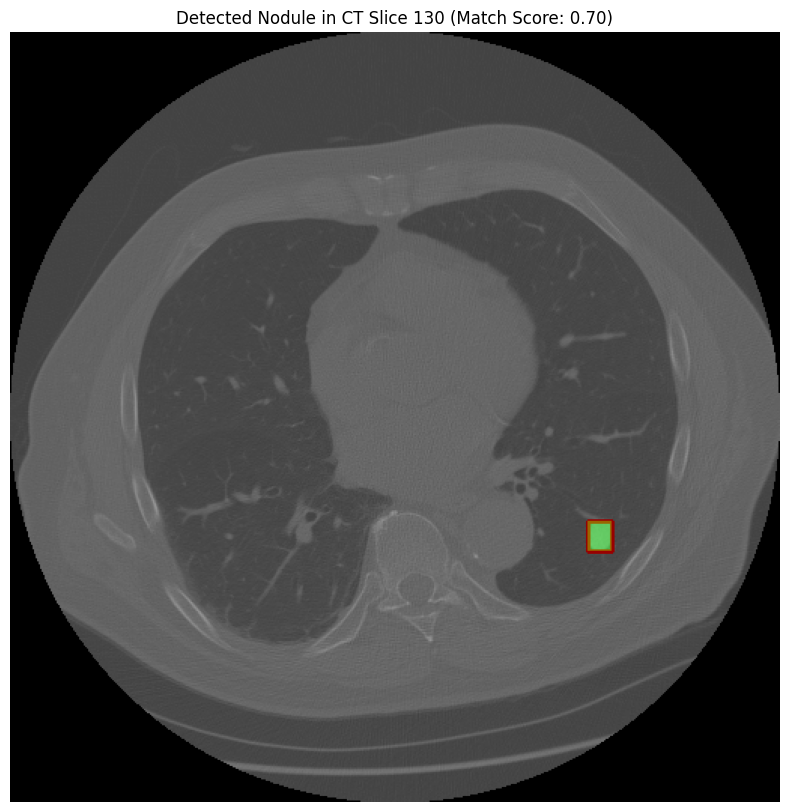

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------
# File paths (adjust if needed)
# -----------------------
ct_scan_path = "../test_processed/3246/3246_full_volume.npy"
mask_path    = "../test_processed/3246/22_asrg_mask.npy"

# -----------------------
# Load the volumes
# -----------------------
ct_volume   = np.load(ct_scan_path)  # CT scan in HU values (full volume)
mask_volume = np.load(mask_path)     # Mask volume (same dimensions; nonzero only at ROI)

# -----------------------
# Extract Template from Mask Volume
# -----------------------
# Choose a slice from the mask volume to extract the nodule template.
# (This slice is used only to get the nodule shape.)
template_slice_index = 129  # adjust as needed
mask_slice = np.squeeze(mask_volume[template_slice_index])

# If the mask is binary (values 0/1), scale it to 0-255 for visualization.
if mask_slice.max() <= 1:
    mask_disp = (mask_slice * 255).astype(np.uint8)
else:
    mask_disp = mask_slice.astype(np.uint8)

# Extract the bounding box of the non-zero region (i.e. the nodule) from the mask.
ys, xs = np.where(mask_disp != 0)
if len(ys) == 0 or len(xs) == 0:
    raise ValueError(f"No non-zero ROI found in mask slice {template_slice_index}")
y_min, y_max = ys.min(), ys.max()
x_min, x_max = xs.min(), xs.max()
template_patch = mask_disp[y_min:y_max+1, x_min:x_max+1]

# Convert the template to float32 (as required by OpenCV matchTemplate)
template_float = template_patch.astype(np.float32)

# -----------------------
# Define parameters for template matching across slices
# -----------------------
match_method = cv2.TM_CCOEFF_NORMED
# Set a threshold for considering a match “good” (adjust as needed)
match_threshold = 0.6
# Tolerance (in pixels) for grouping hits with similar location
tol = 5

# List to hold the matching results for each slice:
# Each entry is a tuple: (slice_index, top_left coordinate, match score)
hits = []

# -----------------------
# Iterate through each CT slice and perform template matching
# -----------------------
n_slices = ct_volume.shape[0]
for i in range(n_slices):
    # Get the CT slice
    ct_slice = np.squeeze(ct_volume[i])
    
    # Normalize the CT slice (HU values can vary widely)
    ct_min = np.min(ct_slice)
    ct_max = np.max(ct_slice)
    ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
    
    # Convert to float32
    ct_norm_float = ct_norm.astype(np.float32)
    
    # Apply template matching using OpenCV
    result = cv2.matchTemplate(ct_norm_float, template_float, match_method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # For TM_CCOEFF_NORMED, a higher value means a better match.
    if max_val >= match_threshold:
        hits.append((i, max_loc, max_val))

# -----------------------
# Group hits by location (within a tolerance) to see if multiple adjacent slices match at similar locations.
# -----------------------
clusters = []
for hit in hits:
    slice_idx, top_left, score = hit
    assigned = False
    # Try to add the hit to an existing cluster if its location is similar
    for cluster in clusters:
        # We use the cluster's representative location (first hit's location) for comparison
        rep_loc = cluster[0][1]
        if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
            cluster.append(hit)
            assigned = True
            break
    if not assigned:
        clusters.append([hit])

if not clusters:
    raise ValueError("No slices passed the matching threshold.")

# For demonstration, choose the cluster with the most hits (i.e. most consistent detection across slices).
best_cluster = max(clusters, key=lambda c: len(c))
# From the best cluster, choose the middle slice (by index)
sorted_cluster = sorted(best_cluster, key=lambda x: x[0])
middle_hit = sorted_cluster[len(sorted_cluster)//2]
sel_slice_idx, sel_top_left, sel_score = middle_hit

# -----------------------
# Display the selected CT slice with the detected region highlighted.
# -----------------------
# Load the chosen slice and normalize for display.
selected_slice = np.squeeze(ct_volume[sel_slice_idx])
ct_min = np.min(selected_slice)
ct_max = np.max(selected_slice)
ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)

# Convert to color image for overlaying colored graphics.
ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)
h, w = template_patch.shape
bottom_right = (sel_top_left[0] + w, sel_top_left[1] + h)
# Draw a red rectangle around the detected match.
cv2.rectangle(ct_color, sel_top_left, bottom_right, (0, 0, 255), 2)

# Optionally add a semi-transparent green overlay.
overlay = ct_color.copy()
alpha = 0.4  # transparency factor
colored_patch = np.zeros_like(ct_color)
colored_patch[sel_top_left[1]:bottom_right[1], sel_top_left[0]:bottom_right[0]] = (0, 255, 0)
cv2.addWeighted(colored_patch, alpha, overlay, 1 - alpha, 0, overlay)

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Nodule in CT Slice {sel_slice_idx} (Match Score: {sel_score:.2f})")
plt.axis("off")
plt.show()


# Creating Templates for Template Matching

In [32]:
import os
import glob
import numpy as np
import pandas as pd

def create_asrg_templates(base_dir="../data_processed"):
    """
    Iterates over RealCancerous and FakeAddedCancer folders,
    reads each class CSV, and for each entry:
      - Locates the patient's asrg_mask files.
      - Extracts the whole 2D mask slice from the mask volume using the slice provided.
    All extracted templates (with some metadata) are stored in a single npy file.
    """
    templates = []
    classes = ["RealCancerous", "FakeAddedCancer"]
    
    for ctype in classes:
        ctype_dir = os.path.join(base_dir, ctype)
        csv_path  = os.path.join(ctype_dir, f"{ctype}.csv")
        
        if not os.path.isfile(csv_path):
            print(f"CSV file not found for {ctype}: {csv_path} (skipping)")
            continue
        
        # Read CSV (columns: uuid, slice, x, y)
        df = pd.read_csv(csv_path)
        
        # Process each CSV row
        for idx, row in df.iterrows():
            uuid_str  = str(row["uuid"])
            slice_idx = int(row["slice"])
            # x_center and y_center could be used for additional verification if needed.
            
            # Locate the patient's folder
            patient_folder = os.path.join(ctype_dir, uuid_str)
            if not os.path.isdir(patient_folder):
                print(f"Patient folder not found: {patient_folder} (skipping)")
                continue
            
            # Find all asrg_mask files in this patient's folder
            mask_files = glob.glob(os.path.join(patient_folder, "*_asrg_mask.npy"))
            if not mask_files:
                print(f"No asrg_mask files found for patient {uuid_str} in {patient_folder}")
                continue
            
            for mfile in mask_files:
                try:
                    mask_volume = np.load(mfile)
                except Exception as e:
                    print(f"Error loading {mfile}: {e}")
                    continue
                
                # Check if the provided slice index is within bounds
                if slice_idx < 0 or slice_idx >= mask_volume.shape[0]:
                    print(f"Slice {slice_idx} is out of bounds for volume in {mfile} (skipping)")
                    continue
                
                # Extract the specified slice from the mask volume
                mask_slice = mask_volume[slice_idx]
                
                # Convert to uint8 (assuming binary mask values 0/1)
                if mask_slice.max() <= 1:
                    mask_disp = (mask_slice * 255).astype(np.uint8)
                else:
                    mask_disp = mask_slice.astype(np.uint8)
                    
                # Check if the entire slice is empty; if so, skip it.
                if np.count_nonzero(mask_disp) == 0:
                    print(f"Empty mask slice for patient {uuid_str} at slice {slice_idx} in {mfile} (skipping)")
                    continue
                
                # Use the entire mask slice as the template.
                template_patch = mask_disp
                
                # Save template along with metadata in a dictionary
                template_dict = {
                    "class": ctype,
                    "uuid": uuid_str,
                    "slice": slice_idx,
                    "mask_file": os.path.basename(mfile),
                    "template": template_patch
                }
                templates.append(template_dict)
                print(f"Extracted template for patient {uuid_str}, slice {slice_idx} from {mfile}")
    
    # Save all templates into a single npy file
    output_filepath = os.path.join(base_dir, "templates.npy")
    np.save(output_filepath, templates, allow_pickle=True)
    print(f"Saved {len(templates)} templates into {output_filepath}")

if __name__ == "__main__":
    create_asrg_templates("../data_processed")


Extracted template for patient 1546, slice 159 from ../data_processed/RealCancerous/1546/1_asrg_mask.npy
Extracted template for patient 1045, slice 103 from ../data_processed/RealCancerous/1045/1_asrg_mask.npy
Extracted template for patient 2244, slice 65 from ../data_processed/RealCancerous/2244/1_asrg_mask.npy
Extracted template for patient 2244, slice 65 from ../data_processed/RealCancerous/2244/2_asrg_mask.npy
Empty mask slice for patient 2244 at slice 65 in ../data_processed/RealCancerous/2244/3_asrg_mask.npy (skipping)
Empty mask slice for patient 2244 at slice 65 in ../data_processed/RealCancerous/2244/4_asrg_mask.npy (skipping)
Extracted template for patient 2244, slice 66 from ../data_processed/RealCancerous/2244/1_asrg_mask.npy
Extracted template for patient 2244, slice 66 from ../data_processed/RealCancerous/2244/2_asrg_mask.npy
Empty mask slice for patient 2244 at slice 66 in ../data_processed/RealCancerous/2244/3_asrg_mask.npy (skipping)
Empty mask slice for patient 2244 a

# Zoomed in Template saving templates1.npy

In [71]:
import os
import glob
import numpy as np
import pandas as pd

def create_asrg_templates(base_dir="../data_processed"):
    """
    Iterates over RealCancerous and FakeAddedCancer folders,
    reads each class CSV, and for each entry:
      - Locates the patient's asrg_mask files.
      - Extracts a 128x128 template from the mask volume using the slice provided,
        by computing the bounding box around nonzero pixels (ROI) and then cutting a
        128x128 patch centered on that ROI.
    All extracted templates (with some metadata) are stored in a single npy file.
    """
    templates = []
    patch_size = 128
    half_size = patch_size // 2
    classes = ["RealCancerous", "FakeAddedCancer"]
    
    for ctype in classes:
        ctype_dir = os.path.join(base_dir, ctype)
        csv_path  = os.path.join(ctype_dir, f"{ctype}.csv")
        
        if not os.path.isfile(csv_path):
            print(f"CSV file not found for {ctype}: {csv_path} (skipping)")
            continue
        
        # Read CSV (columns: uuid, slice, x, y)
        df = pd.read_csv(csv_path)
        
        # Process each CSV row
        for idx, row in df.iterrows():
            uuid_str  = str(row["uuid"])
            slice_idx = int(row["slice"])
            
            # Locate the patient's folder
            patient_folder = os.path.join(ctype_dir, uuid_str)
            if not os.path.isdir(patient_folder):
                print(f"Patient folder not found: {patient_folder} (skipping)")
                continue
            
            # Find all asrg_mask files in this patient's folder
            mask_files = glob.glob(os.path.join(patient_folder, "*_asrg_mask.npy"))
            if not mask_files:
                print(f"No asrg_mask files found for patient {uuid_str} in {patient_folder}")
                continue
            
            for mfile in mask_files:
                try:
                    mask_volume = np.load(mfile)
                except Exception as e:
                    print(f"Error loading {mfile}: {e}")
                    continue
                
                # Check if the provided slice index is within bounds
                if slice_idx < 0 or slice_idx >= mask_volume.shape[0]:
                    print(f"Slice {slice_idx} is out of bounds for volume in {mfile} (skipping)")
                    continue
                
                # Extract the specified slice from the mask volume
                mask_slice = mask_volume[slice_idx]
                
                # Convert to uint8 (assuming binary mask values 0/1)
                if mask_slice.max() <= 1:
                    mask_disp = (mask_slice * 255).astype(np.uint8)
                else:
                    mask_disp = mask_slice.astype(np.uint8)
                    
                # Find the bounding box of nonzero pixels in this slice
                nonzero_indices = np.argwhere(mask_disp != 0)
                if nonzero_indices.size == 0:
                    # If no ROI exists in this slice, skip it.
                    continue
                y_min, x_min = nonzero_indices.min(axis=0)
                y_max, x_max = nonzero_indices.max(axis=0)
                
                # Compute the center of the ROI (bounding box center)
                center_y = int((y_min + y_max) // 2)
                center_x = int((x_min + x_max) // 2)
                
                # Define initial patch boundaries (128x128) around the center
                y_start = center_y - half_size
                x_start = center_x - half_size
                y_end = center_y + half_size
                x_end = center_x + half_size
                
                H, W = mask_disp.shape
                # Adjust boundaries if they exceed the image limits
                if y_start < 0:
                    y_end += abs(y_start)
                    y_start = 0
                if x_start < 0:
                    x_end += abs(x_start)
                    x_start = 0
                if y_end > H:
                    diff = y_end - H
                    y_start = max(0, y_start - diff)
                    y_end = H
                if x_end > W:
                    diff = x_end - W
                    x_start = max(0, x_start - diff)
                    x_end = W
                
                # Extract the patch from the mask slice
                template_patch = mask_disp[y_start:y_end, x_start:x_end]
                
                # If the patch is not exactly 128x128, adjust by cropping/padding.
                ph, pw = template_patch.shape
                # Crop if larger than desired size
                if ph > patch_size:
                    start = (ph - patch_size) // 2
                    template_patch = template_patch[start:start+patch_size, :]
                if pw > patch_size:
                    start = (pw - patch_size) // 2
                    template_patch = template_patch[:, start:start+patch_size]
                # Pad if smaller than desired size
                ph, pw = template_patch.shape
                if ph < patch_size or pw < patch_size:
                    pad_top = (patch_size - ph) // 2
                    pad_bottom = patch_size - ph - pad_top
                    pad_left = (patch_size - pw) // 2
                    pad_right = patch_size - pw - pad_left
                    template_patch = np.pad(template_patch, 
                                            ((pad_top, pad_bottom), (pad_left, pad_right)), 
                                            mode='constant', constant_values=0)
                
                # Save template along with metadata in a dictionary
                template_dict = {
                    "class": ctype,
                    "uuid": uuid_str,
                    "slice": slice_idx,
                    "mask_file": os.path.basename(mfile),
                    "template": template_patch
                }
                templates.append(template_dict)
                print(f"Extracted template for patient {uuid_str}, slice {slice_idx} from {mfile}")
    
    # Save all templates into a single npy file
    output_filepath = os.path.join(base_dir, "templates1.npy")
    np.save(output_filepath, templates, allow_pickle=True)
    print(f"Saved {len(templates)} templates into {output_filepath}")

if __name__ == "__main__":
    create_asrg_templates("../data_processed")


Extracted template for patient 1546, slice 159 from ../data_processed/RealCancerous/1546/1_asrg_mask.npy
Extracted template for patient 1045, slice 103 from ../data_processed/RealCancerous/1045/1_asrg_mask.npy
Extracted template for patient 2244, slice 65 from ../data_processed/RealCancerous/2244/1_asrg_mask.npy
Extracted template for patient 2244, slice 65 from ../data_processed/RealCancerous/2244/2_asrg_mask.npy
Extracted template for patient 2244, slice 66 from ../data_processed/RealCancerous/2244/1_asrg_mask.npy
Extracted template for patient 2244, slice 66 from ../data_processed/RealCancerous/2244/2_asrg_mask.npy
Extracted template for patient 2244, slice 97 from ../data_processed/RealCancerous/2244/3_asrg_mask.npy
Extracted template for patient 2244, slice 108 from ../data_processed/RealCancerous/2244/4_asrg_mask.npy
Extracted template for patient 6031, slice 51 from ../data_processed/RealCancerous/6031/1_asrg_mask.npy
Extracted template for patient 6031, slice 64 from ../data_pr

# Testing Template Matching

In [78]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------
# Adjustable file paths
# -----------------------
ct_scan_path   = "../test_processed/3246/3246_full_volume.npy"  # Adjust as needed.
templates_path = "../data_processed/templates.npy"              # File containing list of template dicts.

# -----------------------
# Load the CT volume and the templates
# -----------------------
ct_volume = np.load(ct_scan_path)  # CT scan in HU values (full volume)
# Each entry in templates_list is a dict with keys like "class", "uuid", "slice", "mask_file", and "template"
templates_list = np.load(templates_path, allow_pickle=True)

# -----------------------
# Define parameters for template matching
# -----------------------
match_method    = cv2.TM_CCOEFF_NORMED
match_threshold = 0.6   # threshold for a "good" match (adjust as needed)
tol             = 5     # tolerance in pixels for grouping hits by similar location

# Global detections will store results across all templates.
# Each detection is a tuple: (template_info, (slice_index, top_left, match_score))
global_detections = []

# -----------------------
# Iterate over each template from templates.npy
# -----------------------
for template_info in templates_list:
    # Get the 2D template patch and convert to float32 for matching.
    template_img   = template_info["template"]
    template_float = template_img.astype(np.float32)
    temp_h, temp_w = template_img.shape

    # List to hold matching hits for this template.
    # Each hit: (slice_index, top_left coordinate, match score)
    hits = []
    
    n_slices = ct_volume.shape[0]
    for i in range(n_slices):
        # Extract and normalize the CT slice.
        ct_slice = np.squeeze(ct_volume[i])
        ct_min = np.min(ct_slice)
        ct_max = np.max(ct_slice)
        ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
        ct_norm_float = ct_norm.astype(np.float32)
        
        # Template matching on the current slice.
        result = cv2.matchTemplate(ct_norm_float, template_float, match_method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        # For TM_CCOEFF_NORMED, higher score indicates a better match.
        if max_val >= match_threshold:
            hits.append((i, max_loc, max_val))
    
    # -----------------------
    # Group hits by similar location (within tolerance)
    # -----------------------
    clusters = []
    for hit in hits:
        slice_idx, top_left, score = hit
        assigned = False
        for cluster in clusters:
            rep_loc = cluster[0][1]  # representative location from first hit in cluster
            if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
                cluster.append(hit)
                assigned = True
                break
        if not assigned:
            clusters.append([hit])
    
    if clusters:
        # For this template, choose the cluster with the most hits.
        best_cluster = max(clusters, key=lambda c: len(c))
        # Then, choose the middle hit (by slice index) from that cluster.
        sorted_cluster = sorted(best_cluster, key=lambda x: x[0])
        middle_hit = sorted_cluster[len(sorted_cluster) // 2]
        global_detections.append((template_info, middle_hit))
        print(f"Template from patient {template_info['uuid']} (mask: {template_info['mask_file']}) "
              f"matched on slice {middle_hit[0]} with score {middle_hit[2]:.2f}")

if not global_detections:
    raise ValueError("No detections found with any template.")

# Choose the best detection among all templates.
best_detection = max(global_detections, key=lambda d: d[1][2])
selected_template_info, (sel_slice_idx, sel_top_left, sel_score) = best_detection
selected_template = selected_template_info["template"]  # This is a binary (or near binary) mask patch.
h, w = selected_template.shape

# -----------------------
# Display the CT slice with the detected region highlighted.
# -----------------------
selected_slice = np.squeeze(ct_volume[sel_slice_idx])
ct_min = np.min(selected_slice)
ct_max = np.max(selected_slice)
ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)

# Define region-of-interest on CT where the template matched.
x, y = sel_top_left
bottom_right = (x + w, y + h)
# Draw a red rectangle around the detected match.
cv2.rectangle(ct_color, sel_top_left, bottom_right, (0, 0, 255), 2)

# -----------------------
# Display side-by-side if match score is over 70%
# -----------------------
if sel_score >= 0.7:
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left: CT slice with detected region
    axs[0].imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"CT Slice {sel_slice_idx}\nMatch Score: {sel_score:.2f}")
    axs[0].axis("off")
    
    # Right: Template mask (displayed in grayscale)
    axs[1].imshow(selected_template, cmap="gray")
    axs[1].set_title(f"Template from Patient {selected_template_info['uuid']}\n({selected_template_info['mask_file']})")
    axs[1].axis("off")
    
    plt.tight_layout()
    plt.show()
else:
    # Otherwise, display only the CT slice.
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
    plt.title(f"CT Slice {sel_slice_idx}\nMatch Score: {sel_score:.2f}")
    plt.axis("off")
    plt.show()


ValueError: No detections found with any template.

# Remove Unwanted Template

In [25]:
import numpy as np
import os

# -----------------------
# File path
# -----------------------
templates_path = "../data_processed/templates.npy"

# -----------------------
# Load the templates
# -----------------------
if os.path.exists(templates_path):
    templates_list = np.load(templates_path, allow_pickle=True)
else:
    raise FileNotFoundError(f"File not found: {templates_path}")

# -----------------------
# Remove templates corresponding to patient 2244
# -----------------------
filtered_templates = [template for template in templates_list if template["uuid"] != "2244"]

# -----------------------
# Save the updated templates.npy
# -----------------------
np.save(templates_path, filtered_templates, allow_pickle=True)

print(f"Removed templates for patient 2244. Updated templates.npy saved successfully.")


Removed templates for patient 2244. Updated templates.npy saved successfully.


# Display a few Templates

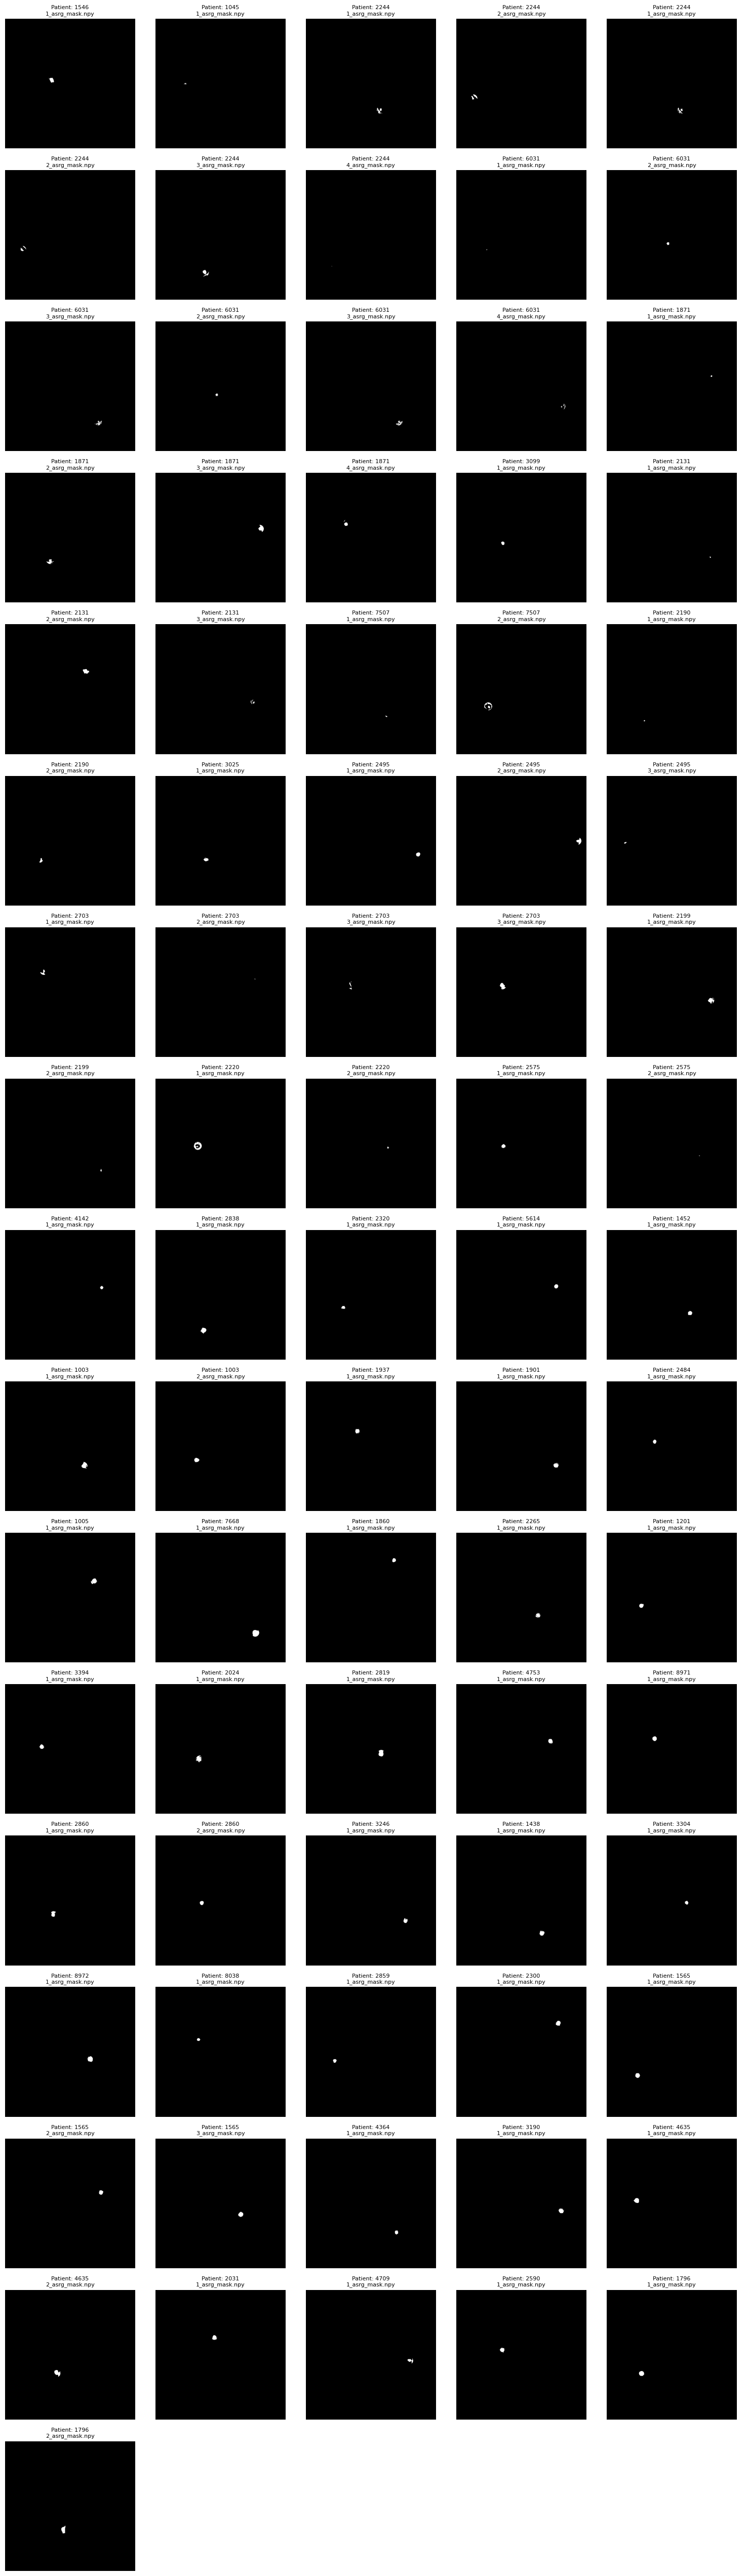

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# File path
# -----------------------
templates_path = "../data_processed/templates.npy"

# -----------------------
# Load the templates
# -----------------------
templates_list = np.load(templates_path, allow_pickle=True)

# -----------------------
# Number of templates to display
# -----------------------
num_templates = len(templates_list)

if num_templates == 0:
    raise ValueError("No templates found in templates1.npy.")

# Determine grid size for visualization
cols = 5  # Set number of columns
rows = (num_templates // cols) + (num_templates % cols > 0)  # Compute rows based on the total number

# -----------------------
# Display all templates
# -----------------------
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # Dynamic figure size based on rows
axes = axes.ravel()  # Flatten axes array for easy iteration

for i in range(num_templates):
    template = templates_list[i]["template"]  # Extract mask
    uuid = templates_list[i]["uuid"]
    mask_file = templates_list[i]["mask_file"]

    axes[i].imshow(template, cmap="gray")
    axes[i].set_title(f"Patient: {uuid}\n{mask_file}", fontsize=8)
    axes[i].axis("off")

# Hide any extra subplots if fewer than (rows * cols) slots were used
for i in range(num_templates, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [84]:
import os
import glob
import numpy as np
import pandas as pd

def create_asrg_templates(base_dir="../data_processed"):
    """
    Iterates over RealCancerous and FakeAddedCancer folders,
    reads each class CSV, and for each entry:
      - Locates the patient's asrg_mask files.
      - Extracts the 2D template from the mask volume using the slice provided.
      - Computes the bounding box around nonzero pixels (ROI).
    All extracted templates (with some metadata) are stored in a single npy file.
    """
    templates = []
    classes = ["RealCancerous", "FakeAddedCancer"]
    
    for ctype in classes:
        ctype_dir = os.path.join(base_dir, ctype)
        csv_path  = os.path.join(ctype_dir, f"{ctype}.csv")
        
        if not os.path.isfile(csv_path):
            print(f"CSV file not found for {ctype}: {csv_path} (skipping)")
            continue
        
        # Read CSV (columns: uuid, slice, x, y)
        df = pd.read_csv(csv_path)
        
        # Process each CSV row
        for idx, row in df.iterrows():
            uuid_str  = str(row["uuid"])
            slice_idx = int(row["slice"])
            # x_center and y_center are provided in CSV but here we use the entire ROI.
            # They could be used to verify that the extracted template is centered appropriately.
            # x_center = row["x"]
            # y_center = row["y"]
            
            # Locate the patient's folder
            patient_folder = os.path.join(ctype_dir, uuid_str)
            if not os.path.isdir(patient_folder):
                print(f"Patient folder not found: {patient_folder} (skipping)")
                continue
            
            # Find all asrg_mask files in this patient's folder
            mask_files = glob.glob(os.path.join(patient_folder, "*_asrg_mask.npy"))
            if not mask_files:
                print(f"No asrg_mask files found for patient {uuid_str} in {patient_folder}")
                continue
            
            for mfile in mask_files:
                try:
                    mask_volume = np.load(mfile)
                except Exception as e:
                    print(f"Error loading {mfile}: {e}")
                    continue
                
                # Check if the provided slice index is within bounds
                if slice_idx < 0 or slice_idx >= mask_volume.shape[0]:
                    print(f"Slice {slice_idx} is out of bounds for volume in {mfile} (skipping)")
                    continue
                
                # Extract the specified slice from the mask volume
                mask_slice = mask_volume[slice_idx]
                
                # Convert to uint8 (assuming binary mask values 0/1)
                if mask_slice.max() <= 1:
                    mask_disp = (mask_slice * 255).astype(np.uint8)
                else:
                    mask_disp = mask_slice.astype(np.uint8)
                    
                # Find the bounding box of nonzero pixels in this slice
                nonzero_indices = np.argwhere(mask_disp != 0)
                if nonzero_indices.size == 0:
                    # If this mask file does not have a ROI at the specified slice, skip it.
                    continue
                y_min, x_min = nonzero_indices.min(axis=0)
                y_max, x_max = nonzero_indices.max(axis=0)
                template_patch = mask_disp[y_min:y_max+1, x_min:x_max+1]
                
                # Save template along with metadata in a dictionary
                template_dict = {
                    "class": ctype,
                    "uuid": uuid_str,
                    "slice": slice_idx,
                    "mask_file": os.path.basename(mfile),
                    "template": template_patch
                }
                templates.append(template_dict)
                print(f"Extracted template for patient {uuid_str}, slice {slice_idx} from {mfile}")
    
    # Save all templates into a single npy file
    output_filepath = os.path.join(base_dir, "templates.npy")
    np.save(output_filepath, templates, allow_pickle=True)
    print(f"Saved {len(templates)} templates into {output_filepath}")

if __name__ == "__main__":
    create_asrg_templates("../data_processed")


Extracted template for patient 1546, slice 159 from ../data_processed/RealCancerous/1546/1_asrg_mask.npy
Extracted template for patient 1045, slice 103 from ../data_processed/RealCancerous/1045/1_asrg_mask.npy
Extracted template for patient 2244, slice 65 from ../data_processed/RealCancerous/2244/1_asrg_mask.npy
Extracted template for patient 2244, slice 65 from ../data_processed/RealCancerous/2244/2_asrg_mask.npy
Extracted template for patient 2244, slice 66 from ../data_processed/RealCancerous/2244/1_asrg_mask.npy
Extracted template for patient 2244, slice 66 from ../data_processed/RealCancerous/2244/2_asrg_mask.npy
Extracted template for patient 2244, slice 97 from ../data_processed/RealCancerous/2244/3_asrg_mask.npy
Extracted template for patient 2244, slice 108 from ../data_processed/RealCancerous/2244/4_asrg_mask.npy
Extracted template for patient 6031, slice 51 from ../data_processed/RealCancerous/6031/1_asrg_mask.npy
Extracted template for patient 6031, slice 64 from ../data_pr

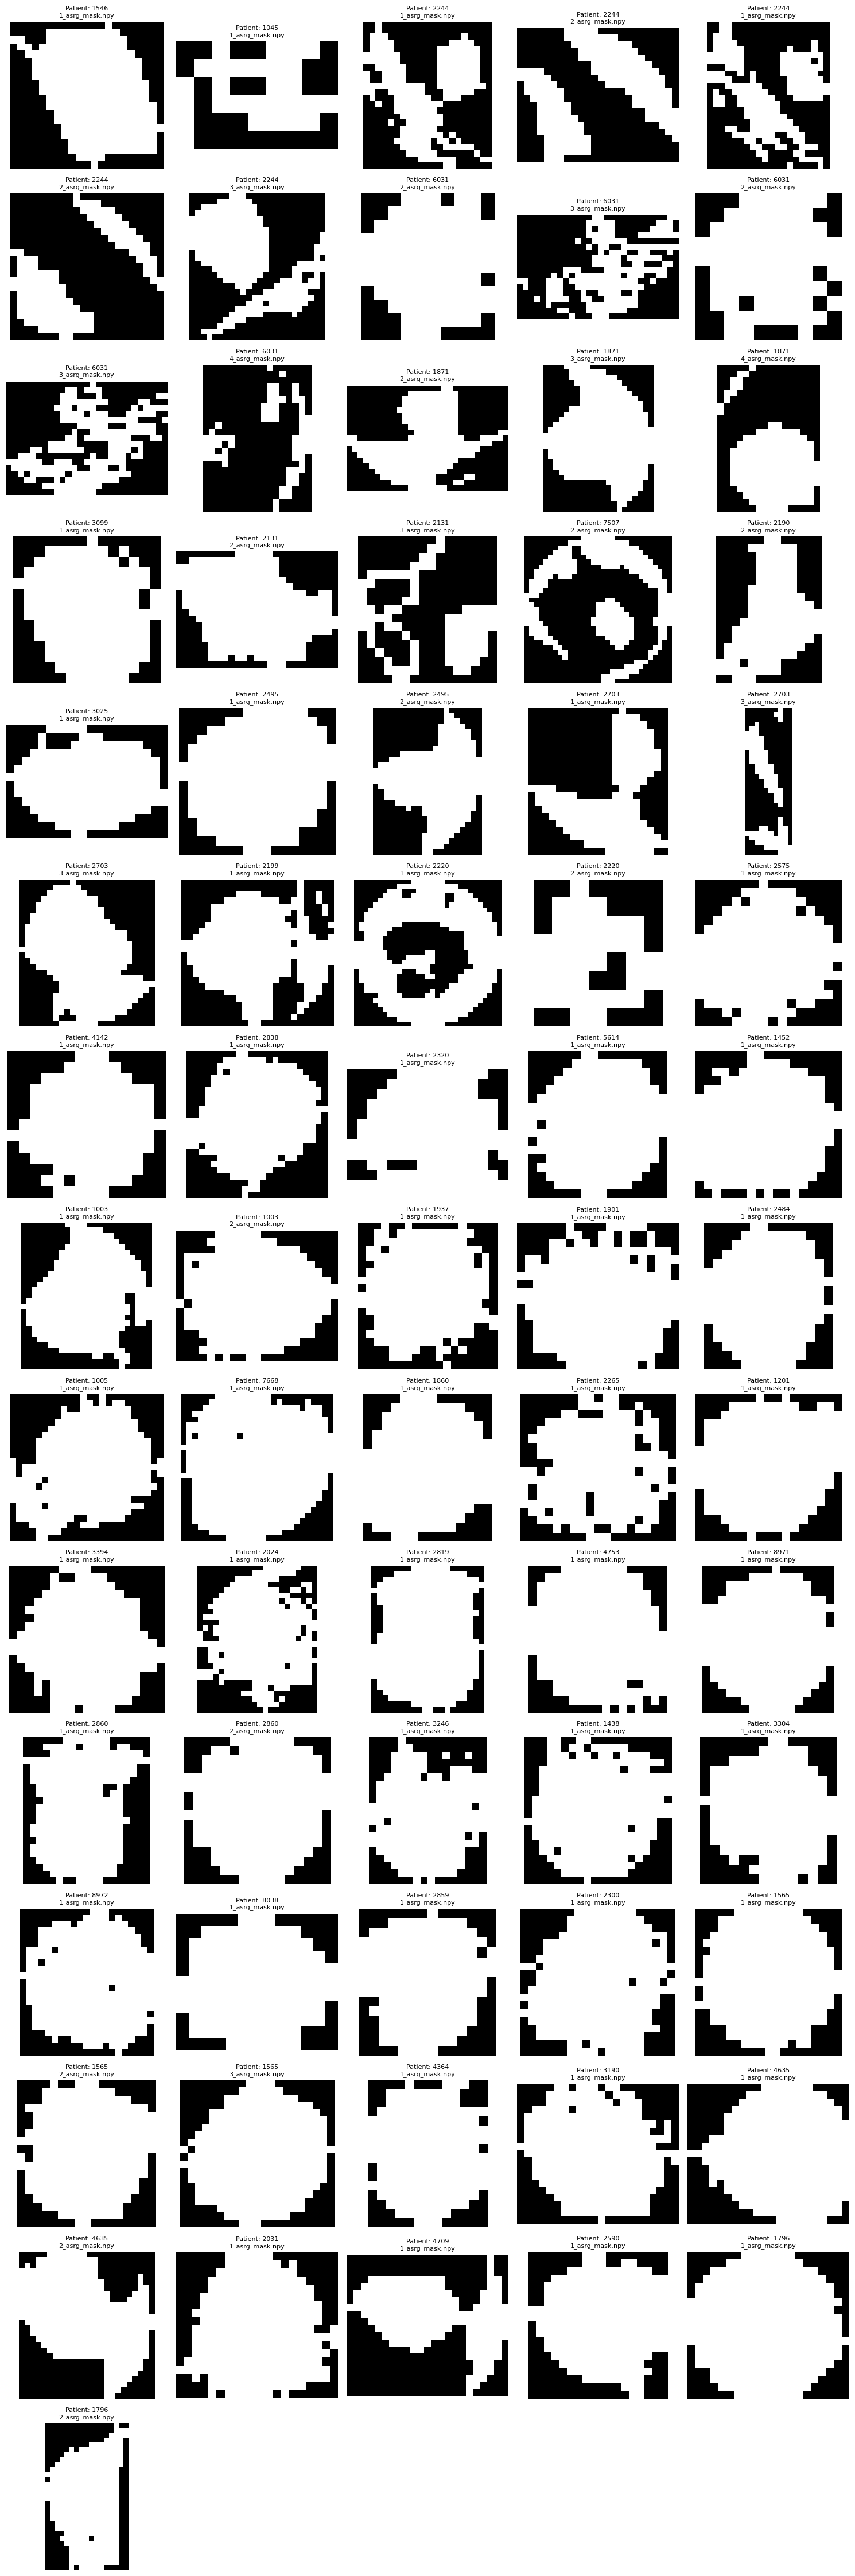

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# File path
# -----------------------
templates_path = "../data_processed/templates.npy"

# -----------------------
# Load the templates
# -----------------------
templates_list = np.load(templates_path, allow_pickle=True)

# -----------------------
# Number of templates to display
# -----------------------
num_templates = len(templates_list)

if num_templates == 0:
    raise ValueError("No templates found in templates.npy.")

# Determine grid size for visualization
cols = 5  # Set number of columns
rows = (num_templates // cols) + (num_templates % cols > 0)  # Compute rows based on the total number

# -----------------------
# Display all templates
# -----------------------
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # Dynamic figure size based on rows
axes = axes.ravel()  # Flatten axes array for easy iteration

for i in range(num_templates):
    template = templates_list[i]["template"]  # Extract mask
    uuid = templates_list[i]["uuid"]
    mask_file = templates_list[i]["mask_file"]

    axes[i].imshow(template, cmap="gray")
    axes[i].set_title(f"Patient: {uuid}\n{mask_file}", fontsize=8)
    axes[i].axis("off")

# Hide any extra subplots if fewer than (rows * cols) slots were used
for i in range(num_templates, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


# Remove Mask_file from Templates

In [55]:
import numpy as np
import os
import sys

# Adjustable parameters:
mask_serial = 1  # Serial number for the mask file (adjust as needed)
template_uuid_to_remove = "2703"  # Template UUID to remove (adjust as needed)

# Construct the mask file name based on the serial number.
mask_file_to_remove = f"{2}_asrg_mask.npy"

# Define the file path for the templates.
template_file_path = "../data_processed/templates.npy"

# Check if the template file exists.
if not os.path.exists(template_file_path):
    print(f"Error: Template file does not exist at '{template_file_path}'.")
    sys.exit(1)

# Load the templates from the file with error handling.
try:
    templates_list = np.load(template_file_path, allow_pickle=True)
except Exception as e:
    print(f"Error loading templates from '{template_file_path}': {e}")
    sys.exit(1)

# Validate that the loaded data is in the expected format.
if not isinstance(templates_list, np.ndarray):
    print("Error: Loaded templates are not in the expected numpy array format.")
    sys.exit(1)

if len(templates_list) == 0:
    print("No templates found in the file. Nothing to remove.")
    sys.exit(0)

# Display the current number of templates for reference.
original_count = len(templates_list)
print(f"Found {original_count} template(s) in the file.")

# Loop through the templates and extract the required keys:
# "template" (mask), "uuid", and "mask_file". Remove any template that matches
# both the specified uuid and mask_file.
updated_templates = []
removed_count = 0

for i in range(len(templates_list)):
    tpl = templates_list[i]
    try:
        # Extract keys as per the display code.
        template_mask = tpl["template"]  # Extract mask (for reference)
        uuid = tpl["uuid"]
        mask_file = tpl["mask_file"]
    except KeyError as e:
        print(f"Error: Missing key {e} in template at index {i}. Skipping this entry.")
        updated_templates.append(tpl)
        continue

    # Check if both uuid and mask_file match the ones to remove.
    if uuid == template_uuid_to_remove and mask_file == mask_file_to_remove:
        removed_count += 1  # This template will be removed.
    else:
        updated_templates.append(tpl)

if removed_count == 0:
    print(f"Error: No matching template found with uuid '{template_uuid_to_remove}' and mask_file '{mask_file_to_remove}'.")
else:
    try:
        # Save the updated list of templates back to the file.
        np.save(template_file_path, np.array(updated_templates, dtype=object))
        print(f"Successfully removed {removed_count} template(s) from the file.")
    except Exception as e:
        print(f"Error saving updated templates to '{template_file_path}': {e}")
        sys.exit(1)


Found 72 template(s) in the file.
Successfully removed 1 template(s) from the file.
